In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

2022-07-26 12:05:30.445828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 12:05:32.992556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:90:00.0, compute capability: 8.0


In [4]:
DATADIR = '/lcrc/project/AIEADA-2/Resnet_data/Weatherbench/5.625'

In [5]:
var_dict = {
    'geopotential': ('z', [50,250,500,600,700,850,925]),
    'temperature': ('t', [50,250,500,600,700,850,925]),
    'u_wind': ('u',[50,250,500,600,700,850,925]),
    'v_wind': ('v',[50,250,500,600,700,850,925]),
    'specific_humidity': ('q',[50,250,500,600,700,850,925]),
    'solar_radiation':('tisr',None),
    'total_precipitation':('tp',None),
    '2m_temperature':('t2m',None),
    'constants': ['lat2d', 'orography', 'lsm']
}

In [6]:
output_vars = ['z_500','t_850']

In [7]:
ds = xr.merge([xr.open_mfdataset(f'{DATADIR}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [8]:
ds_train = ds.sel(time=slice('2000', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [9]:
filters = [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 2]
kernels = [7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
lead_time = 72
lr = 0.5e-4
early_stopping_patience = 5
reduce_lr_patience = 2
min_es_delta = 0.0001
data_subsample = 1
norm_subsample = 30000
bn_position = 'post'
network_type = 'resnet'
dropout = 0.5
l2 = 1e-5
tp_log=0.001
activation = 'leakyrelu'
nt = 3
dt = 6
loss = 'lat_mse'
batch_size = 32
#relu_idxs = 0
discard_first = 24

In [10]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample,tp_log=0.001
)
dg_valid = DataGenerator(
    ds_valid, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars,tp_log=0.001
)
dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars,tp_log=0.001
)
#tp_log=0.001

/home/cledoux/.conda/envs/Rasp_env/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/cledoux/.conda/envs/Rasp_env/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key

In [11]:
class ChannelSlice(tf.keras.layers.Layer):

    def __init__(self, n_out, **kwargs):
        self.n_out = n_out
        super().__init__(**kwargs)

    def _slice(self, inputs):
        # Input: [samples, lat, lon, filters]
        return inputs[..., :self.n_out]

    def __call__(self, inputs):
        out = Lambda(self._slice)(inputs)
        return out

In [12]:
def convblock(inputs, filters, kernel=3, stride=1, bn_position='post', l2=1e-5,
              use_bias=True, dropout=0.1,activation='leakyrelu'):
    x = inputs
    if bn_position == 'pre': x = BatchNormalization()(x)
    x = PeriodicConv2D(
        filters, kernel, conv_kwargs={
            'kernel_regularizer': regularizers.l2(l2),
            'use_bias': use_bias
        }
    )(x)
    if bn_position == 'mid': x = BatchNormalization()(x)
    x = LeakyReLU()(x) if activation == 'leakyrelu' else Activation(activation)(x) 
    if bn_position == 'post': x = BatchNormalization()(x)
    if dropout > 0: x = Dropout(dropout)(x)
    return x

In [13]:
def build_resnet(filters, kernels, input_shape, bn_position='post', use_bias=True, l2=1e-5,
                 skip=True, dropout=0.1,activation='leakyrelu',**kwargs):
    x = input = Input(shape=input_shape)
    # First conv block to get up to shape
    x = convblock(
        x, filters[0], kernels[0], bn_position=bn_position, l2=l2, use_bias=use_bias,
        dropout=dropout, activation=activation
    )
    
    # Resblocks
    for f, k in zip(filters[1:-1], kernels[1:-1]):
        y = x
        for _ in range(2):
            x = convblock(
                x, f, k, bn_position=bn_position, l2=l2, use_bias=use_bias,
                dropout=dropout
            )
        if skip: x = Add()([y, x])
    
    # Final convolution
    output = PeriodicConv2D(
        filters[-1], kernels[-1],
        conv_kwargs={'kernel_regularizer': regularizers.l2(l2)},
    )(x)
    return keras.models.Model(input, output)

In [14]:
model = build_resnet(filters, kernels,
                     input_shape=(32, 64, len(dg_train.data.level)),
                     bn_position='post', skip=False, dropout=0.1)

2022-07-26 12:09:45.804613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:90:00.0, compute capability: 8.0


In [15]:
def create_lat_mse(lat):
    weights_lat = np.cos(np.deg2rad(lat)).values
    weights_lat /= weights_lat.mean()
    def lat_mse(y_true, y_pred):
        error = y_true - y_pred
        mse = ((error)**2 * weights_lat[None, : , None, None])
        return mse
    return lat_mse

In [16]:
lmse = create_lat_mse(dg_train.data.lat)

In [17]:
model.compile(keras.optimizers.Adam(lr),lmse, metrics=['mse'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 64, 41)]      0         
                                                                 
 periodic_conv2d (PeriodicCo  (None, 32, 64, 128)      257280    
 nv2D)                                                           
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 64, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 64, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 64, 128)       0         
                                                                 
 periodic_conv2d_1 (Periodic  (None, 32, 64, 128)      147584

In [19]:
#model.load_weights("Resnet_trial_5_no_precip_2000_2015.h5")

In [19]:
callbacks = []
if early_stopping_patience is not None:
    callbacks.append(tf.keras.callbacks.EarlyStopping(
          patience=early_stopping_patience,
          verbose=1,
          min_delta=min_es_delta,
          mode='auto',
          restore_best_weights=1
                      ))
if reduce_lr_patience is not None:
    callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(
            patience=reduce_lr_patience,
            factor=0.2,
            verbose=1,
            min_lr=0.2**1*lr,
        ))

In [20]:
model.fit_generator(dg_train, epochs=150, callbacks=callbacks)

/tmp/ipykernel_2484195/2565875241.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dg_train, epochs=150, callbacks=callbacks)


Epoch 1/150


2022-07-26 12:10:11.422862: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-26 12:10:14.954984: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


4381/4381 [==============================] - 529s 117ms/step - loss: 0.1342 - mse: 0.1848 - lr: 5.0000e-05
Epoch 2/150
4381/4381 [==============================] - 513s 117ms/step - loss: 0.0780 - mse: 0.0602 - lr: 5.0000e-05
Epoch 3/150
4381/4381 [==============================] - 517s 118ms/step - loss: 0.0622 - mse: 0.0386 - lr: 5.0000e-05
Epoch 4/150
4381/4381 [==============================] - 515s 117ms/step - loss: 0.0513 - mse: 0.0329 - lr: 5.0000e-05
Epoch 5/150
4381/4381 [==============================] - 515s 117ms/step - loss: 0.0434 - mse: 0.0300 - lr: 5.0000e-05
Epoch 6/150
4381/4381 [==============================] - 514s 117ms/step - loss: 0.0375 - mse: 0.0279 - lr: 5.0000e-05
Epoch 7/150
4381/4381 [==============================] - 514s 117ms/step - loss: 0.0330 - mse: 0.0265 - lr: 5.0000e-05
Epoch 8/150
4381/4381 [==============================] - 514s 117ms/step - loss: 0.0296 - mse: 0.0253 - lr: 5.0000e-05
Epoch 9/150
4381/4381 [==============================] - 514

KeyboardInterrupt: 

In [22]:
model.evaluate(dg_valid)

273/273 [==============================] - 11s 36ms/step - loss: 0.0182 - mse: 0.0237


[0.018194088712334633, 0.023663582280278206]

In [23]:
model.get_weights()

[array([[[[ 3.66226467e-03,  1.40013243e-03, -1.23263791e-03, ...,
           -1.45207124e-03, -3.38219525e-03,  3.04002804e-03],
          [-6.86691282e-03,  3.76090896e-03, -3.62865604e-03, ...,
           -6.40580477e-03, -2.72008148e-03,  4.16144170e-03],
          [ 1.21367280e-03,  4.70066350e-03, -2.51934188e-03, ...,
            1.92808197e-03, -3.38721531e-03, -9.76106618e-03],
          ...,
          [-2.60203873e-04, -9.10543092e-03,  2.83802021e-03, ...,
            1.40659875e-04, -8.95248202e-04,  9.39795189e-03],
          [-1.55932959e-02, -1.54107774e-03,  1.04447629e-03, ...,
            3.03397508e-04,  4.34335973e-03, -1.68867945e-03],
          [-9.04212054e-03,  9.19778831e-03, -7.61816790e-03, ...,
           -1.89496372e-02,  2.24903245e-02,  3.76795931e-03]],
 
         [[ 3.52503639e-03, -1.06097572e-02, -4.90395445e-03, ...,
           -2.56516825e-04,  1.06238329e-03,  5.63470507e-03],
          [-2.61924649e-03,  3.40910186e-03,  1.04657095e-03, ...,
     

In [24]:
model.save("Resnet_trial_6_precip_2000_2015.h5")


In [27]:
unique_vars = ['tp','z','t','u','v','q','tisr','t2m']

In [29]:
preds = create_predictions(model, dg_test)

In [30]:
pred_nc = xr.Dataset.to_netcdf(preds)[0]

In [31]:
valdir = '/lcrc/project/AIEADA-2/Resnet_data/Weatherbench/5.625'
z500_valid = load_test_data(f'{valdir}/geopotential', 'z')
t850_valid = load_test_data(f'{valdir}/temperature', 't')
valid = xr.merge([z500_valid, t850_valid]).load()

In [32]:
valid = valid.isel(time=slice(0,None,6))

In [34]:
def get_direct_scores_from_nc(lead_times, func=compute_weighted_rmse, mean_dims=xr.ALL_DIMS):
    scores = []
    scores.append(
        func(
            pred_nc, 
            valid,
            mean_dims
        ).load()
    )
    return scores

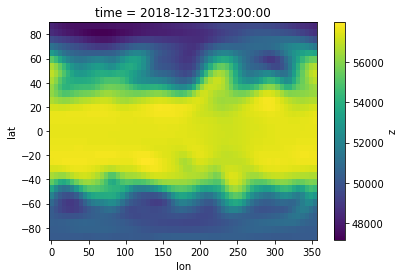

In [36]:
preds.isel(time=-1).z.plot()

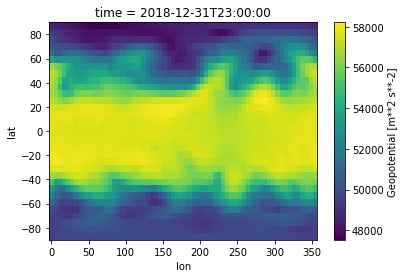

In [37]:
z500_valid.isel(time=-1).plot()